In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam

In [2]:
# Data directory
data_dir = r'D:\major project\archive\OC'

# Data Preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  #  Preprocessing specific to ResNet50
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 752 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [3]:
# Load ResNet50 without top layer (for custom classifier)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile and train the model (feature extraction phase)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=validation_generator, epochs=15)

# --- Fine-tuning phase ---

# Unfreeze last few layers of the base model
for layer in base_model.layers[-10:]:  # Unfreezing last 10 layers, adjust as needed
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again (fine-tuning)
history =model.fit(train_generator, validation_data=validation_generator, epochs=5)

# Save the fine-tuned model
model.save('resnet50_oral_cancer_model.h5')


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6827 - loss: 0.7379

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6865 - loss: 0.7306 - val_accuracy: 0.8138 - val_loss: 0.4572
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8622 - loss: 0.3397 - val_accuracy: 0.8404 - val_loss: 0.3672
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8805 - loss: 0.2867 - val_accuracy: 0.8723 - val_loss: 0.3051
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8893 - loss: 0.2589 - val_accuracy: 0.8404 - val_loss: 0.3777
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8951 - loss: 0.2632 - val_accuracy: 0.8670 - val_loss: 0.3265
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9146 - loss: 0.2180 - val_accuracy: 0.7766 - val_loss: 0.4537
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8989 - loss: 0.2625 - val_accuracy: 0.8351 - val_loss: 0.3283
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9225 - loss: 0.1998 - val_accuracy: 0.8245 - val_loss: 0.3685
Epo

In [4]:
# Predict on validation data
val_preds = model.predict(validation_generator, verbose=1)
val_preds_binary = (val_preds > 0.5).astype(int).flatten()

# True labels
y_true = validation_generator.classes

# Class labels mapping
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, val_preds_binary, target_names=class_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
              precision    recall  f1-score   support

      cancer       0.88      0.88      0.88        98
  non cancer       0.87      0.87      0.87        90

    accuracy                           0.87       188
   macro avg       0.87      0.87      0.87       188
weighted avg       0.87      0.87      0.87       188



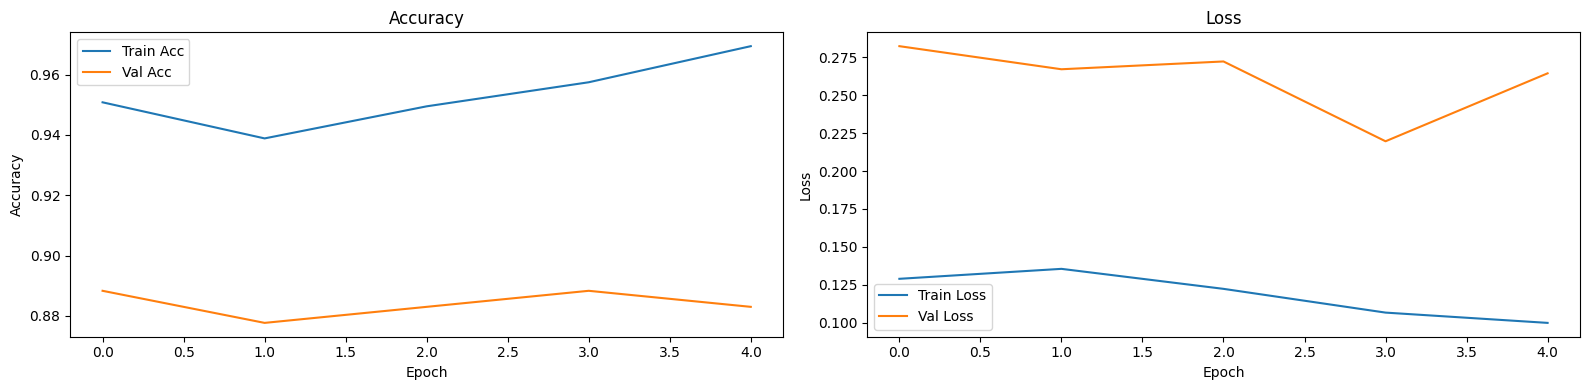

1/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


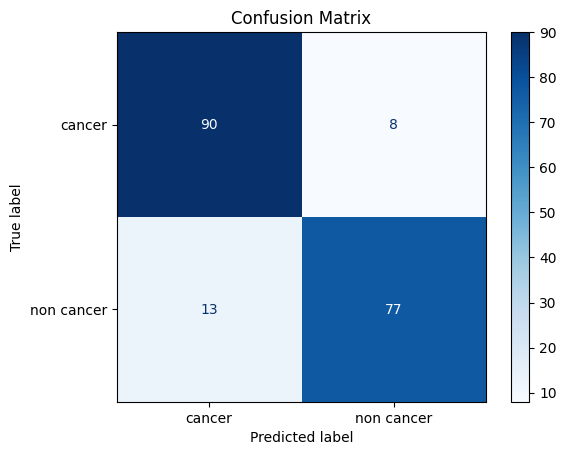

In [5]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [6]:



# Image prediction function
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))  #  ResNet50 preprocess
    prediction = model.predict(img_array)

    if prediction[0][0] < 0.5:
        return "Cancer Detected"
    else:
        return "No Cancer Detected"







In [7]:
# Test on new image
print(train_generator.class_indices)
img_path = r"D:\major project\archive\OC\cancer\002.jpeg"

result = predict_image(img_path)
print(result)

{'cancer': 0, 'non cancer': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Cancer Detected
